# Introduction to W&B 
## weights and biases - AI developer tool

<!--- @wandbcode{dlai_01} -->

We will add `wandb` to sprite classification model training, so that we can track and visualize important metrics, gain insights into our model's behavior and make informed decisions for model improvements. We will also see how to compare and analyze different experiments, collaborate with team members, and reproduce results effectively.

Goal: to classify the sprite in one of 5 classes: hero, non-hero, food, spell, and side-facing

In [3]:
# !pip install wandb

In [4]:
import math
from pathlib import Path
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from utilities_ import get_dataloaders

import wandb

### Sprite classification

We will build a simple model to classify sprites. You can see some examples of sprites and corresponding classes in the image below.

<img src="sprite_sample.png" alt="Alt Text" width="700"/>

In [5]:
INPUT_SIZE = 3 * 16 * 16
OUTPUT_SIZE = 5
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ["hero", "non-hero", "food", "spell", "side-facing"]
DATA_DIR = Path('./data/')
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "Simple MLP with Dropout"
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
        nn.BatchNorm1d(HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    ).to(DEVICE)

In [6]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 2,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [7]:
def train_model(config):
    "Train a model with a given config"

    wandb.init(
        project="dlai_intro",
        config=config,
    )

    # Get the data
    train_dl, valid_dl = get_dataloaders(DATA_DIR,
                                         config.batch_size,
                                         config.slice_size,
                                         config.valid_pct)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            # let w and b do the work
            wandb.log(metrics)

        # Compute validation metrics, log images on last epoch
        val_loss, accuracy = validate_model(model, valid_dl, loss_func)
        # Compute train and validation metrics
        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": accuracy
        }
        wandb.log(val_metrics)

    wandb.finish()


In [8]:
def validate_model(model, valid_dl, loss_func):
    "Compute the performance of the model on the validation dataset"
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


### W&B account
The next cell will log you into the Weights and Biases site anonymously, that is without a unique login. You can also sign up for a free account if you wish to save your work, but that is not needed to finish the course.

In [9]:
wandb.login(anonymous="allow")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Train model
Let's train the model with default config and check how it's doing in W&B.

In [13]:
train_model(config)

In [12]:
# So let's change the learning rate to a 1e-3
# and see how this affects our results.
config.lr = 1e-4
train_model(config)
# basically, sends the training info to the wandb and it will help you visualize everything

  0%|          | 0/2 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
train/example_ct,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/train_loss,███▇▆▆▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁
val/val_accuracy,▁█
val/val_loss,█▁
train/epoch,2
train/example_ct,16000
train/train_loss,0.33039
val/val_accuracy,0.9455
val/val_loss,0.3262


Saving wandb_board.png to wandb_board.png


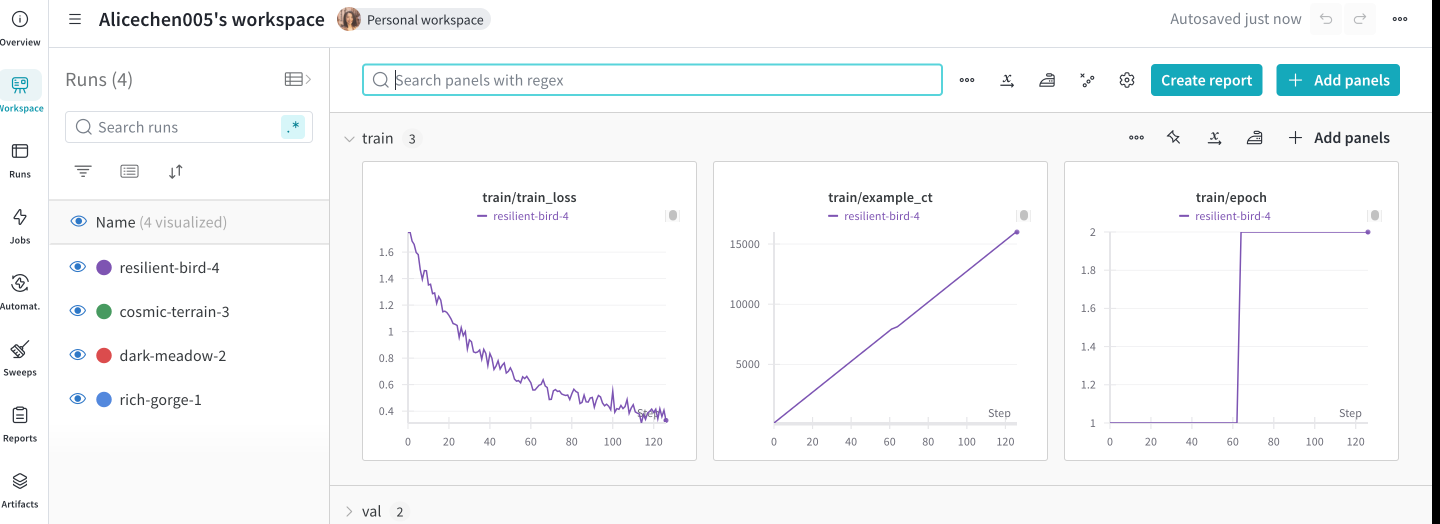

In [14]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='screenshots/wandb_board.png')


In [15]:
config.lr = 1e-4
train_model(config)

  0%|          | 0/2 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████████████
train/example_ct,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
train/train_loss,██▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂
val/val_accuracy,▁█
val/val_loss,█▁
train/epoch,2
train/example_ct,16000
train/train_loss,0.40436
val/val_accuracy,0.9455
val/val_loss,0.34224


Saving wandb_board2.png to wandb_board2.png


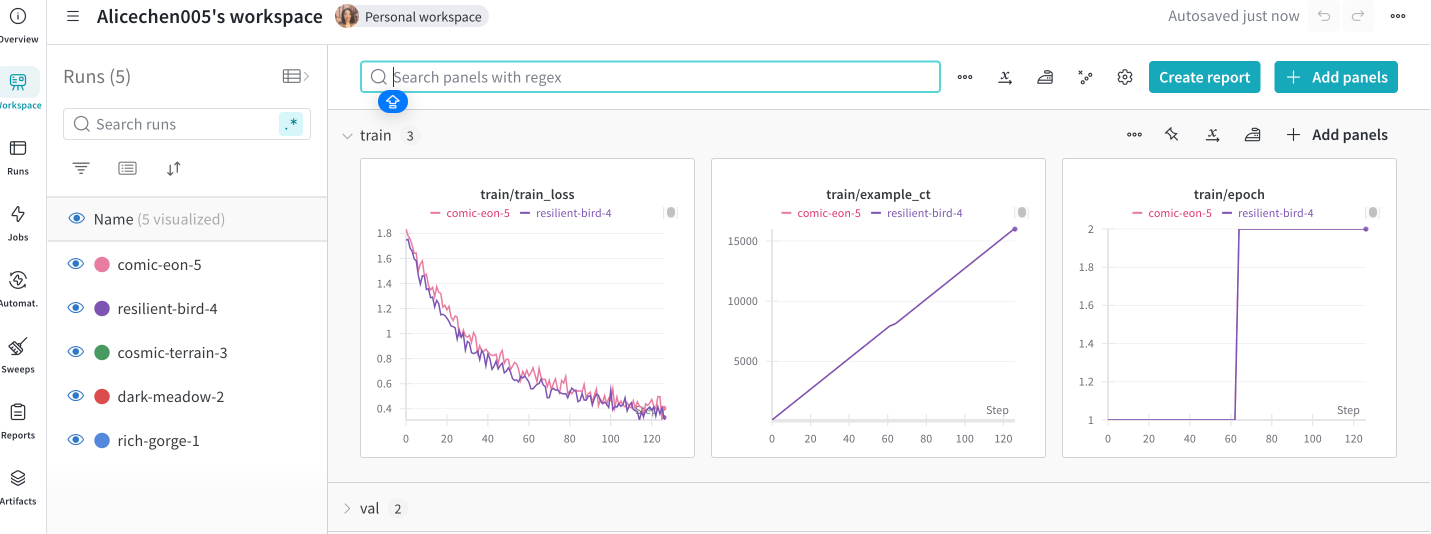

In [16]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='screenshots/wandb_board2.png')

In [17]:
config.dropout = 0.1
config.epochs = 1
train_model(config)
# even shows you how different runs have different metrics and you can evaluate them dynamically
# compare with different hyperparamters, dropout, learning rate, etc.

  0%|          | 0/1 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/example_ct,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train/train_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁
val/val_accuracy,▁
val/val_loss,▁
train/epoch,1
train/example_ct,8000
train/train_loss,0.46829
val/val_accuracy,0.8975
val/val_loss,0.52528


Saving wandb_board3.png to wandb_board3.png


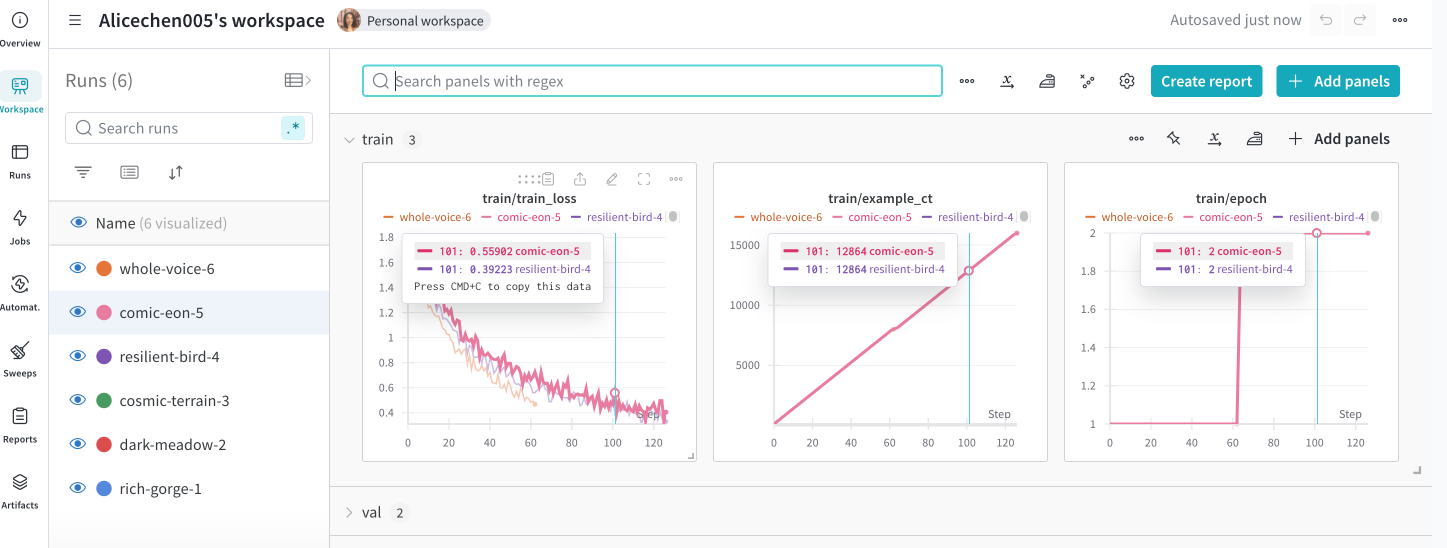

In [18]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='screenshots/wandb_board3.png')

In [19]:
config.lr = 1e-3
train_model(config)

  0%|          | 0/1 [00:00<?, ?it/s]

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/example_ct,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/train_loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁
val/val_loss,▁
train/epoch,1
train/example_ct,8000
train/train_loss,0.05641
val/val_accuracy,0.994
val/val_loss,0.06968


Saving wandb_board4.png to wandb_board4.png


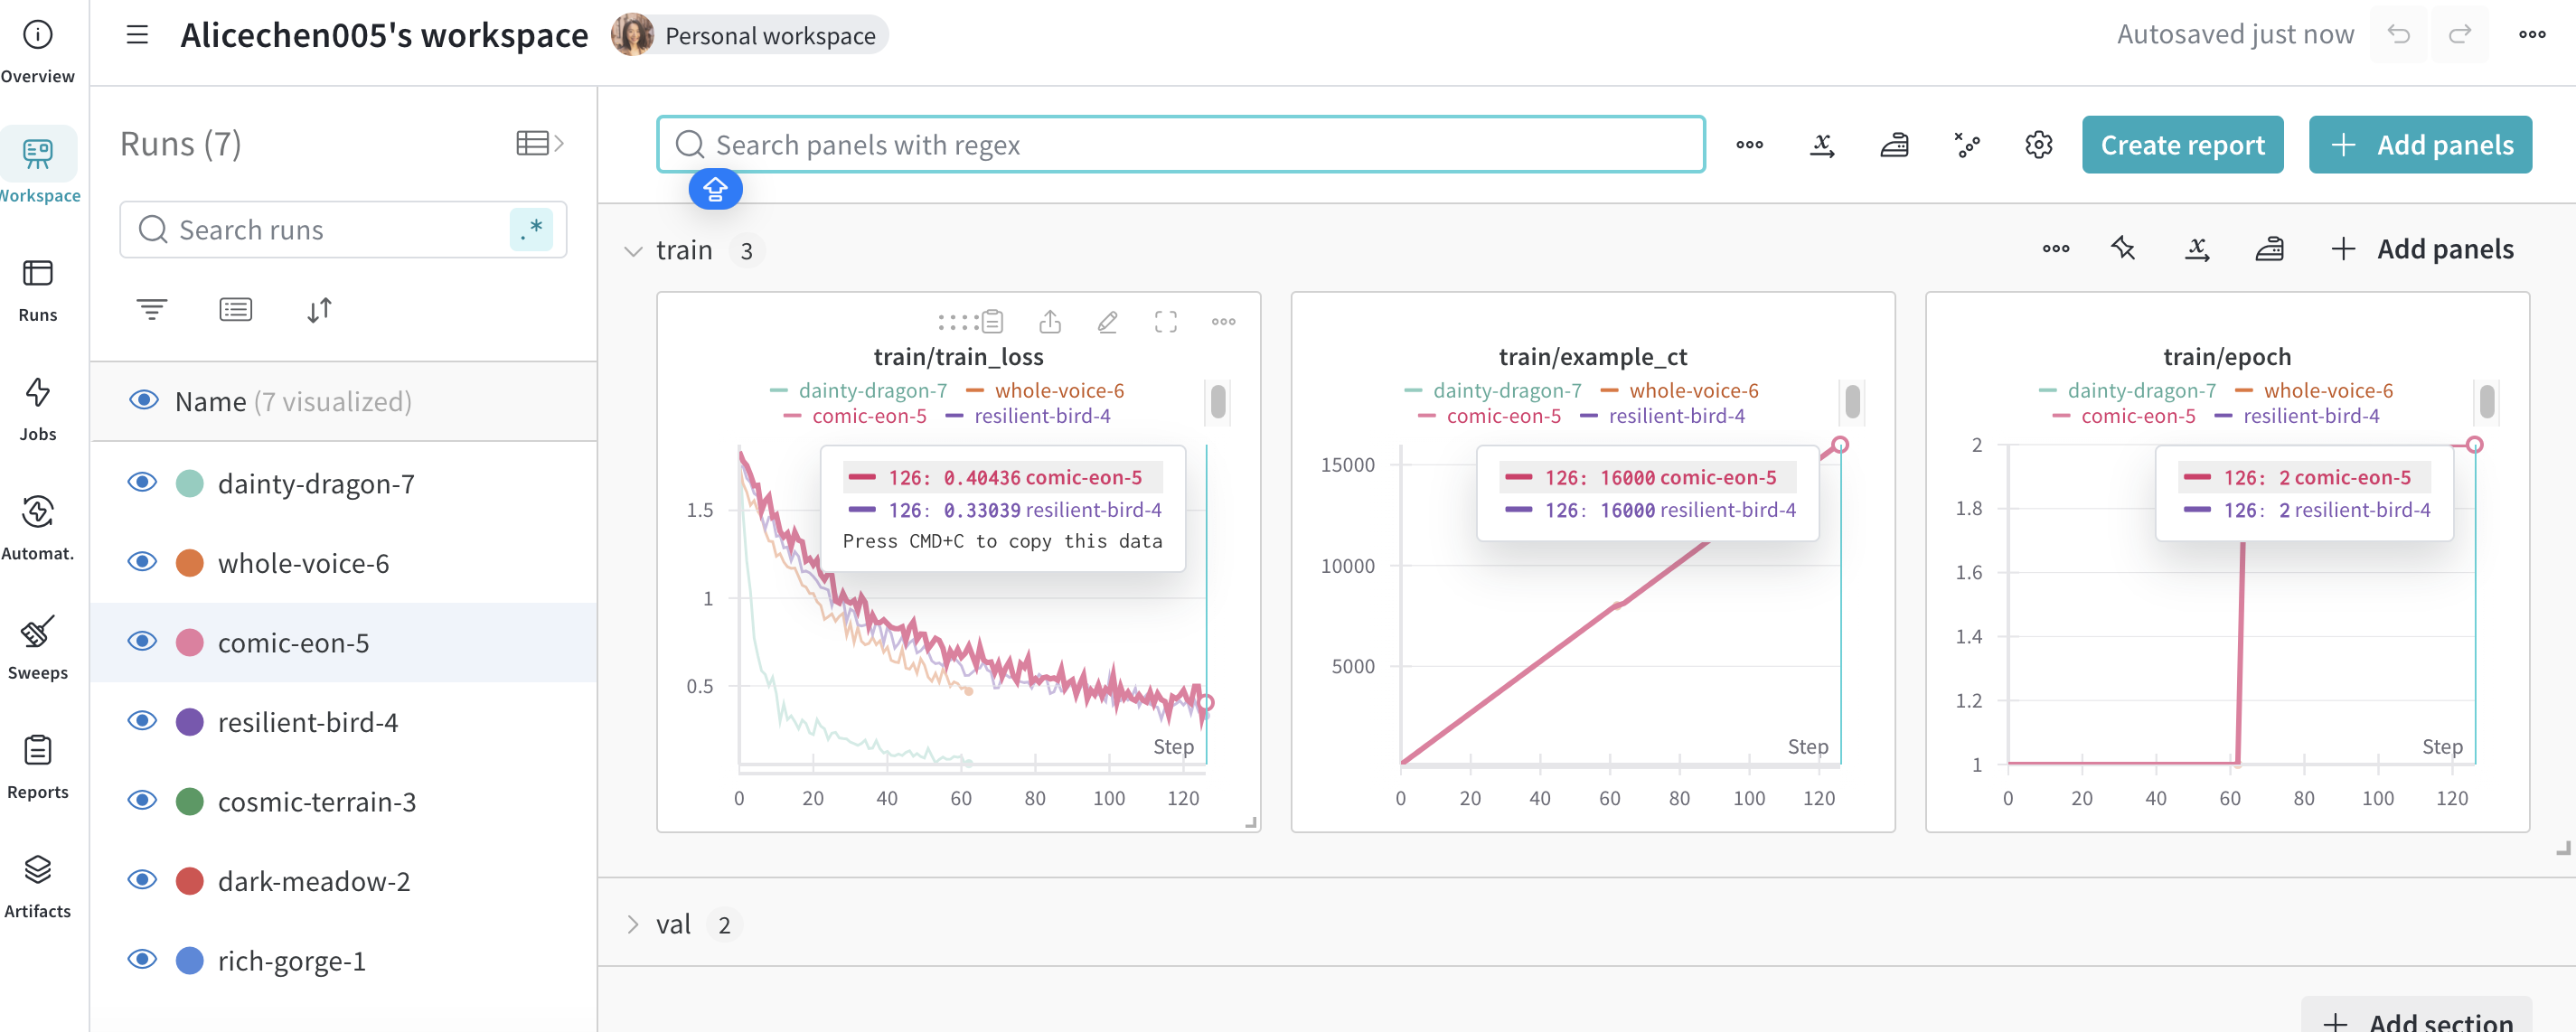

In [20]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='screenshots/wandb_board4.png')

Saving wandb_board5.png to wandb_board5.png


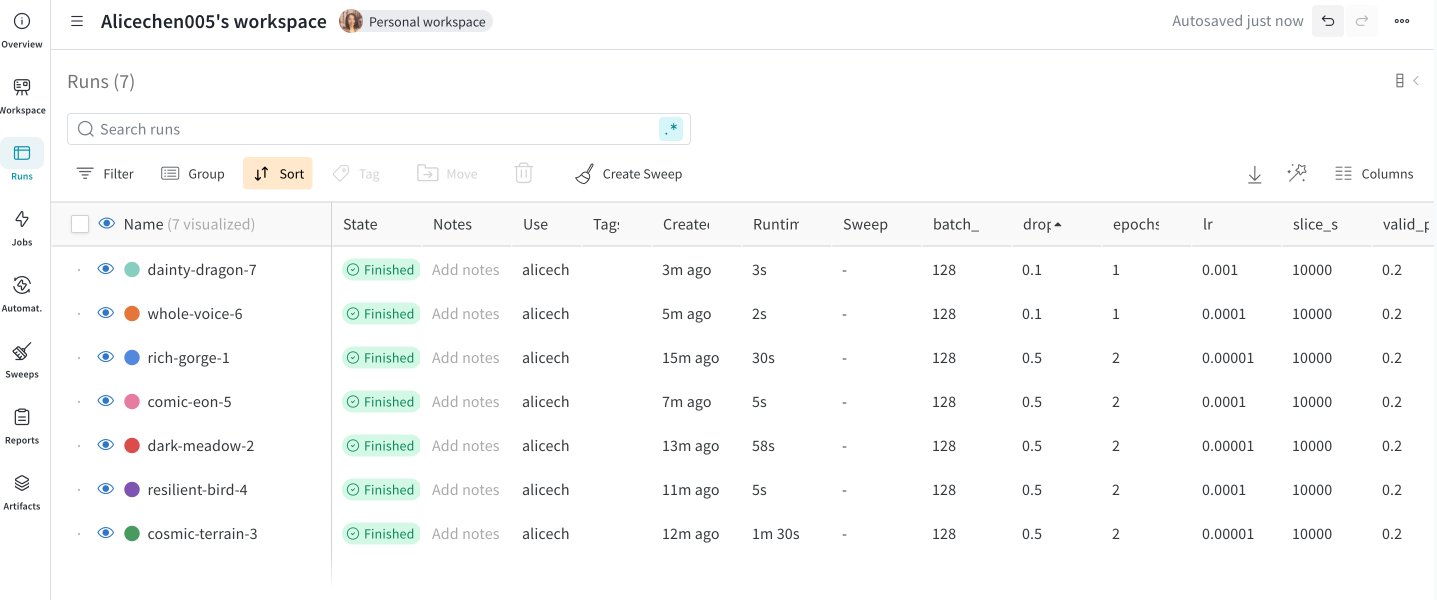

In [22]:
# shows the "Runs" dahsboard:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='screenshots/wandb_board5.png')

# Summary 
## W&B can even see the details of the runs, details, sort, filter, also show the git repo, states, command etc
- tweak the hyperparameter in the codes, and the web records everything.
- each run has a different training curve in terms of loss, val-acc, val-loss
- in "Runes", you can see the batch_size, dropout, epochs, lr, slice_size... you can even customize it to add motes,
- you can also serach for accuracy in the manage columns, to only see certain runs.
- filter, you can filter out the accuracy that is >= 0.95 etc.
- especially great for hundreds of runs
- diff.patch shows the uncommitted changes.
- able to reproduce the runs
- can send the reports/setting/data to people. Therefore, it is easy to communicate with other engineers to check out the settings of the model (the hyperparameters etc)
- great for debugging
- great for checking out a particular env, codes, dataset etc

# next, the training of a genAI model and see how the tools can be used there.